#Load Image

Image shape: (240, 240, 155)


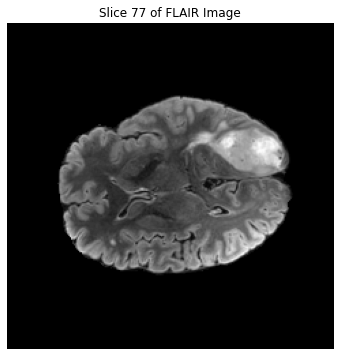

In [ ]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the NIfTI file (.nii.gz format)
file_path = 'Downloads/BraTS2021_00495/BraTS2021_00495_flair.nii.gz'  # Replace with actual file path
img = nib.load(file_path)

# Get the image data as a numpy array
img_data = img.get_fdata()

# Check the shape of the data (it is a 3D image)
print(f"Image shape: {img_data.shape}")

# Let's visualize a middle slice of the 3D image
slice_num = img_data.shape[2] // 2  # Middle slice along the 3rd dimension

# Plot the selected slice
plt.figure(figsize=(6, 6))
plt.imshow(img_data[:, :, slice_num], cmap='gray')
plt.title(f'Slice {slice_num} of FLAIR Image')
plt.axis('off')
plt.show()


#Histogram Equalization

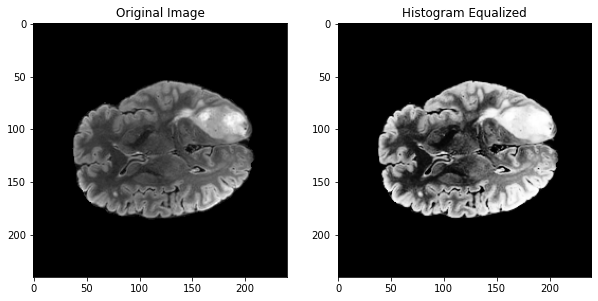

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure

slice_num = img_data.shape[2] // 2
flair_image = img_data[:, :, slice_num]

# Apply Histogram Equalization
equalized_image = exposure.equalize_hist(flair_image)

# Display the original and equalized images
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(flair_image, cmap='gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(equalized_image, cmap='gray'), plt.title('Histogram Equalized')
plt.show()

#Contrast Stretch

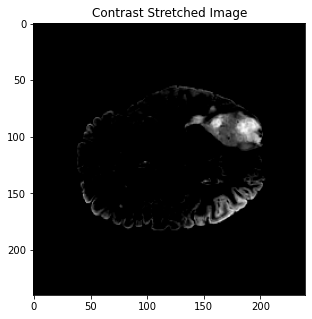

In [ ]:
# Contrast Stretching using exposure rescale intensity
p94, p100 = np.percentile(flair_image, (93, 100))
contrast_stretched_image = exposure.rescale_intensity(flair_image, in_range=(p94, p100))

# Display the contrast-stretched image
plt.figure(figsize=(5,5))
plt.imshow(contrast_stretched_image, cmap='gray')
plt.title('Contrast Stretched Image')
plt.show()


#Unsharp Mask

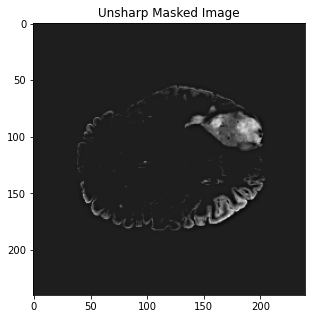

In [ ]:
import cv2

# Unsharp Masking for edge enhancement
blurred = cv2.GaussianBlur(contrast_stretched_image, (9, 9), 10.0)
unsharp_image = cv2.addWeighted(contrast_stretched_image, 1.5, blurred, -0.5, 0)

# Display the unsharp mask result
plt.figure(figsize=(5,5))
plt.imshow(unsharp_image, cmap='gray')
plt.title('Unsharp Masked Image')
plt.show()


#Contrast Stretchx2

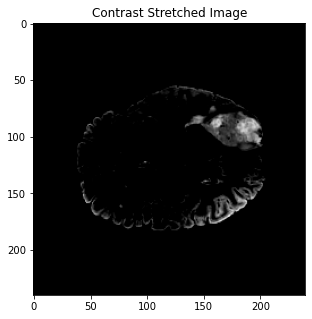

In [ ]:
# Contrast Stretching using exposure rescale intensity
p94, p100 = np.percentile(unsharp_image, (85, 100))
contrast_stretched_image = exposure.rescale_intensity(unsharp_image, in_range=(p94, p100))

# Display the contrast-stretched image
plt.figure(figsize=(5,5))
plt.imshow(contrast_stretched_image, cmap='gray')
plt.title('Contrast Stretched Image')
plt.show()


#LBP Texture Extractor

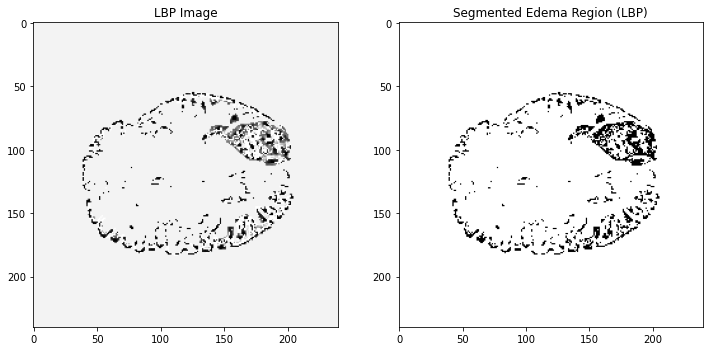

In [ ]:
from skimage.feature import local_binary_pattern
import cv2
import matplotlib.pyplot as plt

# Parameters for LBP
radius = 3  # Radius of the neighborhood
n_points = 8 * radius  # Number of points to consider around each pixel

# Compute the Local Binary Pattern (LBP) of the FLAIR slice
lbp_image = local_binary_pattern(contrast_stretched_image, n_points, radius, method="uniform")

# Normalize the LBP image
lbp_image_normalized = cv2.normalize(lbp_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Apply a threshold to segment the edema based on texture
_, lbp_thresh = cv2.threshold(lbp_image_normalized, 190, 255, cv2.THRESH_BINARY)

# Display the LBP result and the thresholded segmentation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(lbp_image_normalized, cmap='gray')
plt.title('LBP Image')

plt.subplot(1, 2, 2)
plt.imshow(lbp_thresh, cmap='gray')
plt.title('Segmented Edema Region (LBP)')

plt.show()


#Adaptive Thresholding

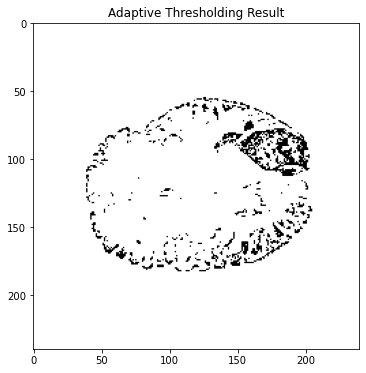

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert the image to 8-bit grayscale if it's not already (OpenCV requires 8-bit images)
flair_slice_8bit = cv2.normalize(lbp_thresh, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(flair_slice_8bit, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 14)

# Display the result
plt.figure(figsize=(6, 6))
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Thresholding Result')
plt.show()


#Shape Based Segmentation

Number of detected contours: 53
Circularity: 0.0, Aspect Ratio: 2.0, Area: 0.0
Circularity: 0.0, Aspect Ratio: 1.5, Area: 0.0
Circularity: 0.3224580264151723, Aspect Ratio: 2.5, Area: 2.0
Circularity: 0.0309741100225652, Aspect Ratio: 2.3333333333333335, Area: 0.5
Circularity: 0.0, Aspect Ratio: 0.5, Area: 0.0
Circularity: 0.0924798546622243, Aspect Ratio: 1.25, Area: 1.0
Circularity: 0.0, Aspect Ratio: 0.5, Area: 0.0
Circularity: 0.09247985475540646, Aspect Ratio: 1.75, Area: 2.0
Circularity: 0.0, Aspect Ratio: 0.5, Area: 0.0
Circularity: 0.15411519865271708, Aspect Ratio: 1.1111111111111112, Area: 14.5
Circularity: 0.0, Aspect Ratio: 0.5, Area: 0.0
Circularity: 0.42253446747912266, Aspect Ratio: 1.75, Area: 8.5
Circularity: 0.0, Aspect Ratio: 1.0, Area: 0.0
Circularity: 0.11699258391727131, Aspect Ratio: 0.7142857142857143, Area: 16.0
Circularity: 0.1760039494727091, Aspect Ratio: 0.75, Area: 16.0
Circularity: 0.27743956426621935, Aspect Ratio: 0.75, Area: 1.5
Circularity: 0.06646137

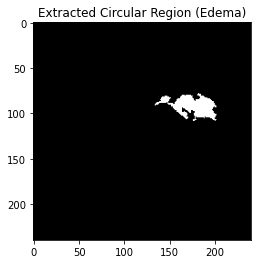

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Ensure the image is 8-bit grayscale
binary_image = cv2.normalize(contrast_stretched_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Apply a threshold to binarize the image if it's not already binary
_, binary_image = cv2.threshold(binary_image, 50, 255, cv2.THRESH_BINARY)

# Now find contours in the thresholded binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize an empty mask to store the circular regions (likely edema)
circular_region_mask = np.zeros_like(binary_image)

# Loop through contours and visualize contour detection
print(f"Number of detected contours: {len(contours)}")  # Print the number of detected contours

for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    # Avoid division by zero
    if perimeter > 0:
        # Compute circularity
        circularity = 4 * np.pi * (area / (perimeter ** 2))
        aspect_ratio = float(cv2.boundingRect(contour)[2]) / float(cv2.boundingRect(contour)[3])  # Width/Height

        print(f"Circularity: {circularity}, Aspect Ratio: {aspect_ratio}, Area: {area}")

        # For now, relax the circularity and aspect ratio conditions
        if 0.105 < circularity <= 5 and 1.8 < aspect_ratio < 2.3:  # Relaxed limits for testing
            cv2.drawContours(circular_region_mask, [contour], -1, 255, -1)  # Draw contour if it meets conditions

# Display the extracted circular regions (and debug output)
plt.imshow(circular_region_mask, cmap='gray')
plt.title('Extracted Circular Region (Edema)')
plt.show()


#Erosion and Dilation

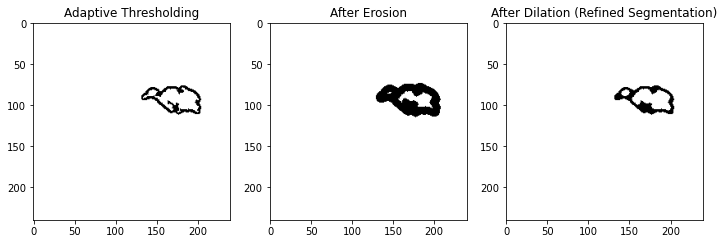

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import erosion, dilation, disk

# Step 1: Convert the FLAIR slice to 8-bit grayscale (required for OpenCV)
flair_slice_8bit = cv2.normalize(circular_region_mask, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

# Step 2: Apply Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(flair_slice_8bit, 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 11)

# Step 3: Apply Morphological Operations (Erosion followed by Dilation)

# Create a structuring element for the operations (size can be adjusted)
selem = disk(3)  # You can increase or decrease the size based on your image

# Apply erosion to remove noise and small artifacts
eroded_image = erosion(adaptive_thresh, selem)

# Apply dilation to restore the main structures after erosion
dilated_image = dilation(eroded_image, selem)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(adaptive_thresh, cmap='gray')
plt.title('Adaptive Thresholding')

plt.subplot(1, 3, 2)
plt.imshow(eroded_image, cmap='gray')
plt.title('After Erosion')

plt.subplot(1, 3, 3)
plt.imshow(dilated_image, cmap='gray')
plt.title('After Dilation (Refined Segmentation)')

plt.show()


#Sobel and Prewitt Edge Detection

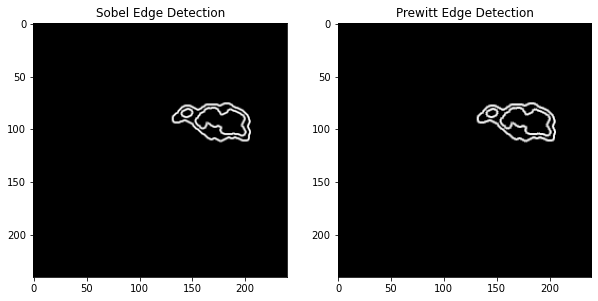

In [ ]:
from skimage import filters

# Sobel Edge Detection
sobel_image = filters.sobel(dilated_image)

# Prewitt Edge Detection
prewitt_image = filters.prewitt(dilated_image)

# Display Sobel and Prewitt results
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(sobel_image, cmap='gray'), plt.title('Sobel Edge Detection')
plt.subplot(122), plt.imshow(prewitt_image, cmap='gray'), plt.title('Prewitt Edge Detection')
plt.show()


#Canny Image

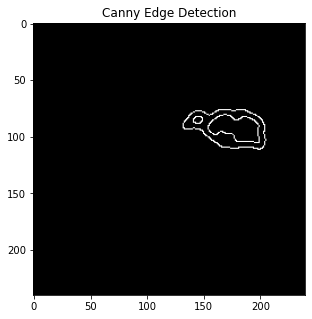

In [ ]:
from skimage.feature import canny

# Apply Canny Edge Detection
canny_edges = canny(dilated_image, sigma=2)

# Display the Canny edge detection result
plt.figure(figsize=(5,5))
plt.imshow(canny_edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.show()


#Spot Overlay

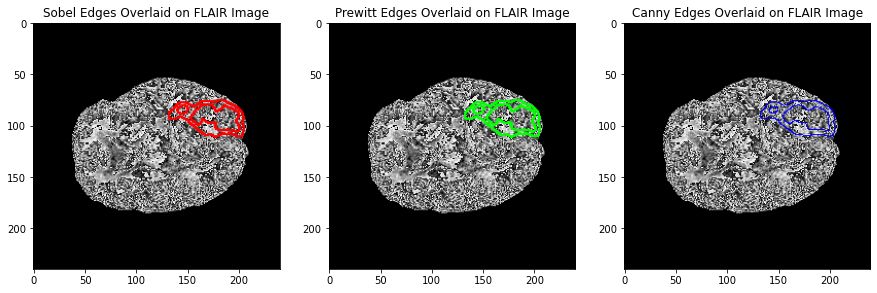

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
from skimage.feature import canny

# Convert the original FLAIR image to RGB
# Convert flair_image to 8-bit unsigned integer if it's not already
flair_image_8bit = flair_image.astype(np.uint8)  # Change data type to uint8
flair_rgb = cv2.cvtColor(flair_image_8bit, cv2.COLOR_GRAY2RGB)

# Sobel Edge Detection
sobel_image = filters.sobel(dilated_image)

# Prewitt Edge Detection
prewitt_image = filters.prewitt(dilated_image)

# Canny Edge Detection
canny_edges = canny(dilated_image, sigma=2)

# Convert edges to boolean mask for overlaying on the FLAIR image
sobel_mask = sobel_image > 0.1  # Apply a threshold to create a binary mask
prewitt_mask = prewitt_image > 0.1
canny_mask = canny_edges > 0

# Create a copy of the FLAIR image for each edge detection method
sobel_overlay = flair_rgb.copy()
prewitt_overlay = flair_rgb.copy()
canny_overlay = flair_rgb.copy()

# Overlay the edges in red
sobel_overlay[sobel_mask] = [255, 0, 0]  # Red color for Sobel edges
prewitt_overlay[prewitt_mask] = [0, 255, 0]  # Green color for Prewitt edges
canny_overlay[canny_mask] = [0, 0, 255]  # Blue color for Canny edges

# Display the original FLAIR image with Sobel, Prewitt, and Canny edges overlaid
plt.figure(figsize=(15, 5))

# Sobel
plt.subplot(131)
plt.imshow(sobel_overlay)
plt.title('Sobel Edges Overlaid on FLAIR Image')

# Prewitt
plt.subplot(132)
plt.imshow(prewitt_overlay)
plt.title('Prewitt Edges Overlaid on FLAIR Image')

# Canny
plt.subplot(133)
plt.imshow(canny_overlay)
plt.title('Canny Edges Overlaid on FLAIR Image')

plt.show()

#Comparison with annotation

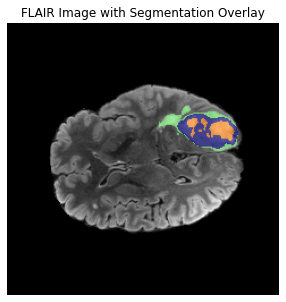

In [ ]:
segmentation_path = 'Downloads/BraTS2021_00495/BraTS2021_00495_seg.nii.gz'  # Replace with segmentation file path
seg_img = nib.load(segmentation_path)
segmentation_data = seg_img.get_fdata()

# Select a middle slice from the 3D volume (z-axis)
slice_num = img_data.shape[2] // 2
segmentation_slice = segmentation_data[:, :, slice_num]
# Convert the FLAIR image to 8-bit grayscale and then to RGB
flair_image_8bit = cv2.normalize(img_data[:, :, slice_num], None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
flair_rgb = cv2.cvtColor(flair_image_8bit, cv2.COLOR_GRAY2RGB)

# Convert the segmentation slice to RGB so it can be overlaid
segmentation_slice_8bit = cv2.normalize(segmentation_slice, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
segmentation_rgb = cv2.applyColorMap(segmentation_slice_8bit, cv2.COLORMAP_JET)  # Apply a colormap to the segmentation

# Create a binary mask for the segmented region (non-zero pixels)
segmentation_mask = segmentation_slice > 0

# Overlay the segmentation only on the segmented regions
overlay_image = flair_rgb.copy()

# Blend only the segmented regions with transparency
alpha = 0.6  # Transparency factor for segmentation overlay
overlay_image[segmentation_mask] = cv2.addWeighted(
    flair_rgb[segmentation_mask], 1 - alpha, segmentation_rgb[segmentation_mask], alpha, 0
)

# Display the original FLAIR image with the segmentation overlay
plt.figure(figsize=(10, 5))
plt.imshow(overlay_image)
plt.title('FLAIR Image with Segmentation Overlay')
plt.axis('off')  # Turn off axis if needed
plt.show()


##Comparison of Segments

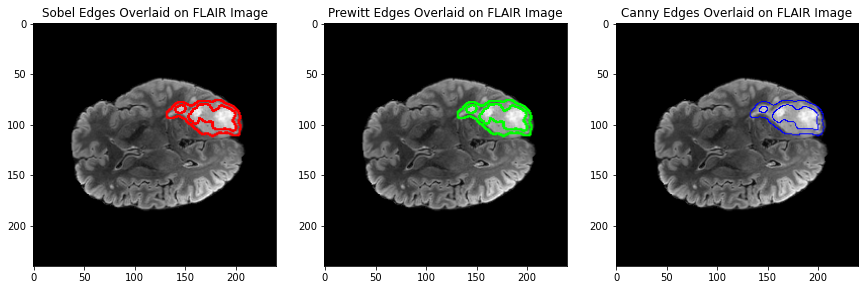

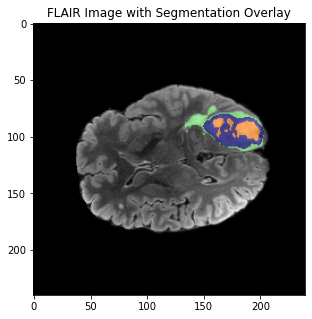

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import filters
from skimage.feature import canny

# Convert the original FLAIR image to 8-bit grayscale and then to RGB
flair_image_8bit = cv2.normalize(flair_image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
flair_rgb = cv2.cvtColor(flair_image_8bit, cv2.COLOR_GRAY2RGB)

# Sobel Edge Detection
sobel_image = filters.sobel(dilated_image)

# Prewitt Edge Detection
prewitt_image = filters.prewitt(dilated_image)

# Canny Edge Detection
canny_edges = canny(dilated_image, sigma=2)

# Convert edges to boolean mask for overlaying on the FLAIR image
sobel_mask = sobel_image > 0.1  # Apply a threshold to create a binary mask
prewitt_mask = prewitt_image > 0.1
canny_mask = canny_edges > 0

# Create a copy of the FLAIR image for each edge detection method
sobel_overlay = flair_rgb.copy()
prewitt_overlay = flair_rgb.copy()
canny_overlay = flair_rgb.copy()

# Overlay the edges in different colors
sobel_overlay[sobel_mask] = [255, 0, 0]  # Red color for Sobel edges
prewitt_overlay[prewitt_mask] = [0, 255, 0]  # Green color for Prewitt edges
canny_overlay[canny_mask] = [0, 0, 255]  # Blue color for Canny edges

# Overlay segmentation mask on the FLAIR image
# Assuming segmentation_slice contains the segmentation mask
segmentation_overlay = flair_rgb.copy()

# Apply a color to the segmented region (e.g., white for the segmented region)
segmentation_mask = segmentation_slice > 0  # Binary mask for segmentation
segmentation_overlay[segmentation_mask] = [255, 24, 255]  # White color for segmentation

# Display the FLAIR image with Sobel, Prewitt, and Canny edges overlaid, plus the segmented image
plt.figure(figsize=(20, 5))

# Sobel Overlay
plt.subplot(141)
plt.imshow(sobel_overlay)
plt.title('Sobel Edges Overlaid on FLAIR Image')

# Prewitt Overlay
plt.subplot(142)
plt.imshow(prewitt_overlay)
plt.title('Prewitt Edges Overlaid on FLAIR Image')

# Canny Overlay
plt.subplot(143)
plt.imshow(canny_overlay)
plt.title('Canny Edges Overlaid on FLAIR Image')


# Display the original FLAIR image with the segmentation mask overlaid
plt.figure(figsize=(10, 5))
plt.imshow(overlay_image)
plt.title('FLAIR Image with Segmentation Overlay')

plt.show()
